<a href="https://colab.research.google.com/github/mouzai-hadil/AllenNeurons/blob/main/Copie_de_load_Allen_Visual_Behavior_from_pre_processed_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Allen Institute Visual Behavior 2P dataset overview
### This dataset consists of neural activity measured with 2-photon calcium imaging in the visual cortex of mice performing an image change detection task.
##### In this task, mice learn to report changes in stimulus identity by licking a spout to earn a water reward.


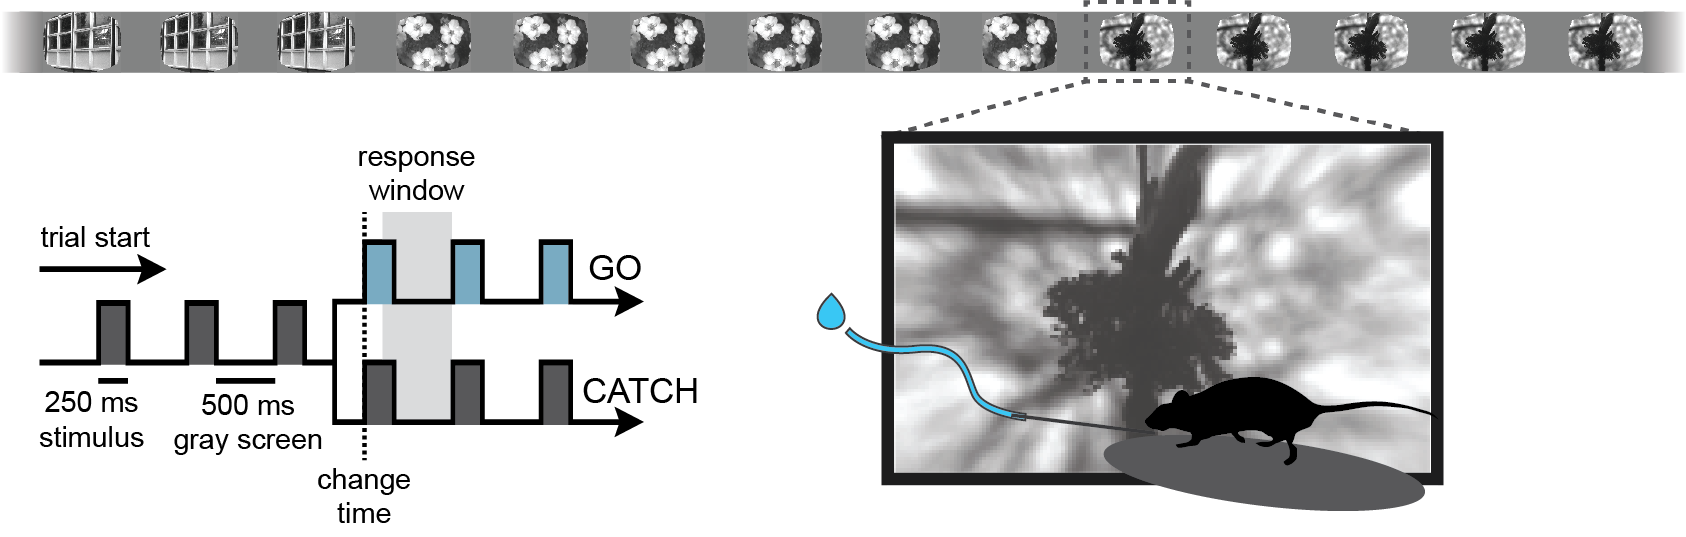

##### In some sessions, the mice perform the task with familiar images they have seen many times during training. In other sessions, mice perform the task with novel images.
##### During 2-photon imaging sessions, 5% of stimulus presentations are randomly omitted, allowing us to examine the effect of unexpected events on neural activity.
##### The same population of cells is imaged over multiple days with varying sensory and behavioral conditions.


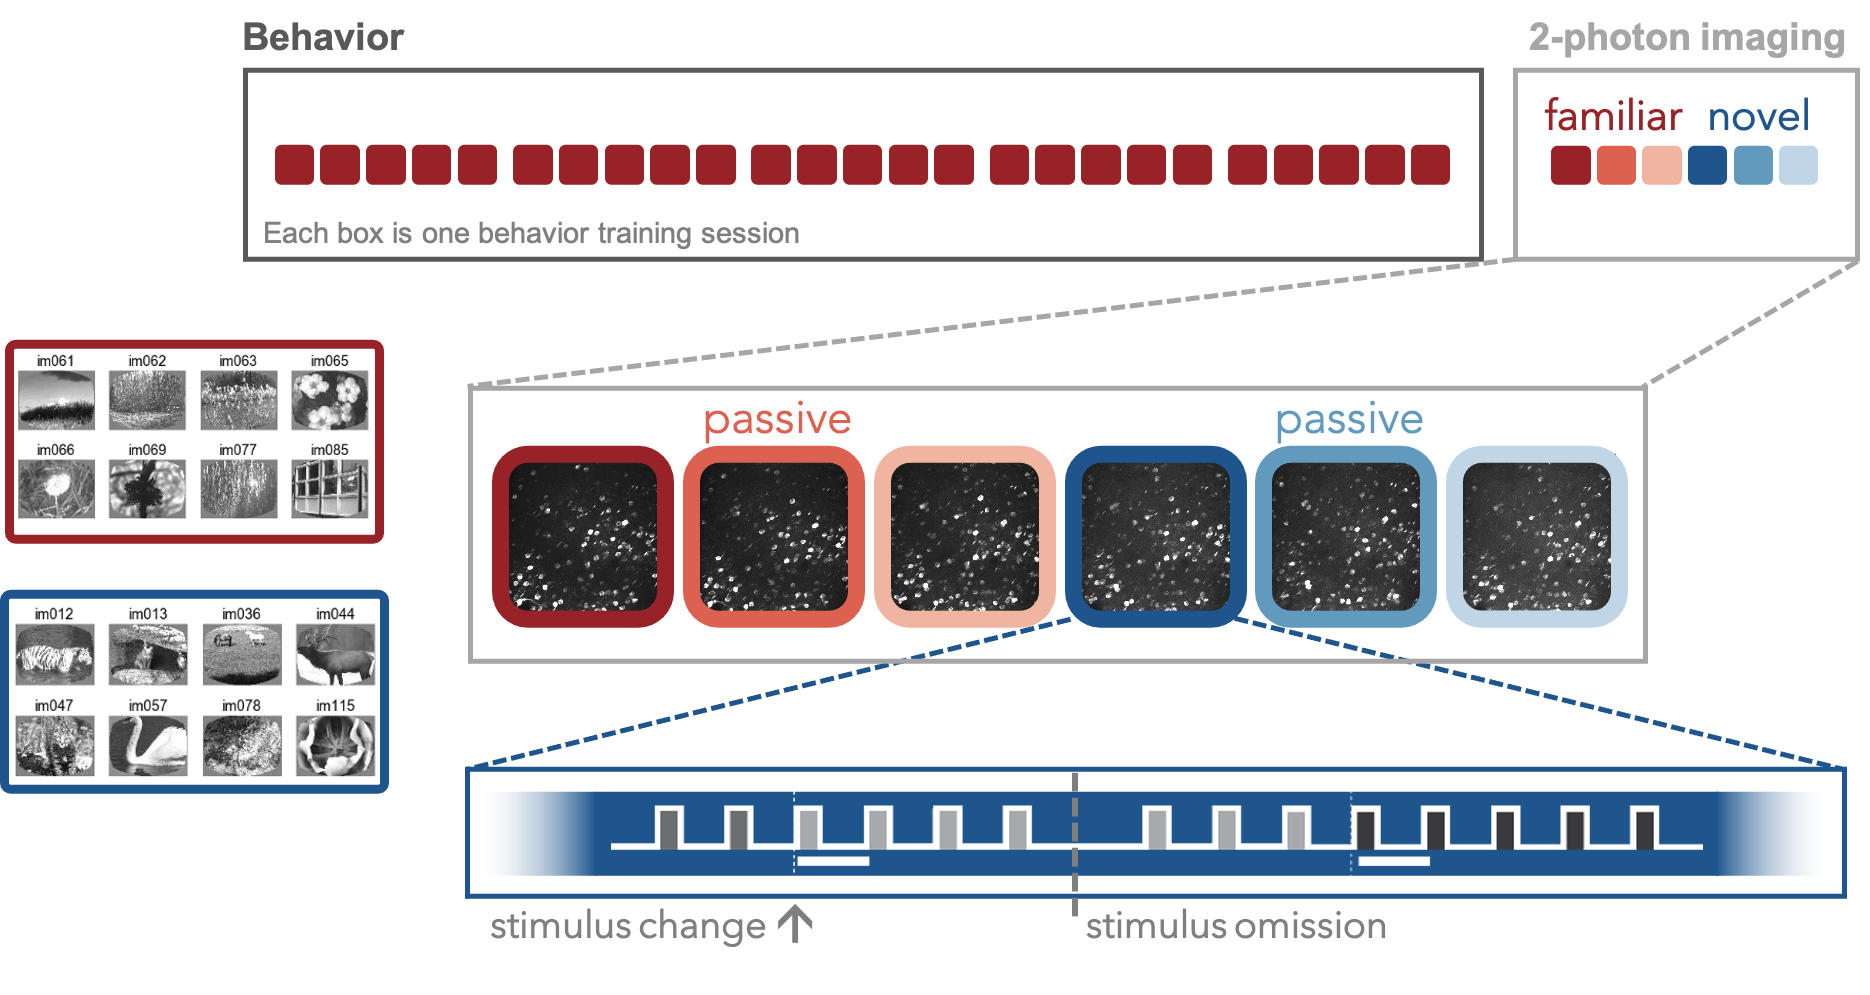

##### Multiple cortical areas and depths were measured concurently in each session, at a sample rate of 11Hz.
##### Data was collected from excitatory and inhibitory neural populations.

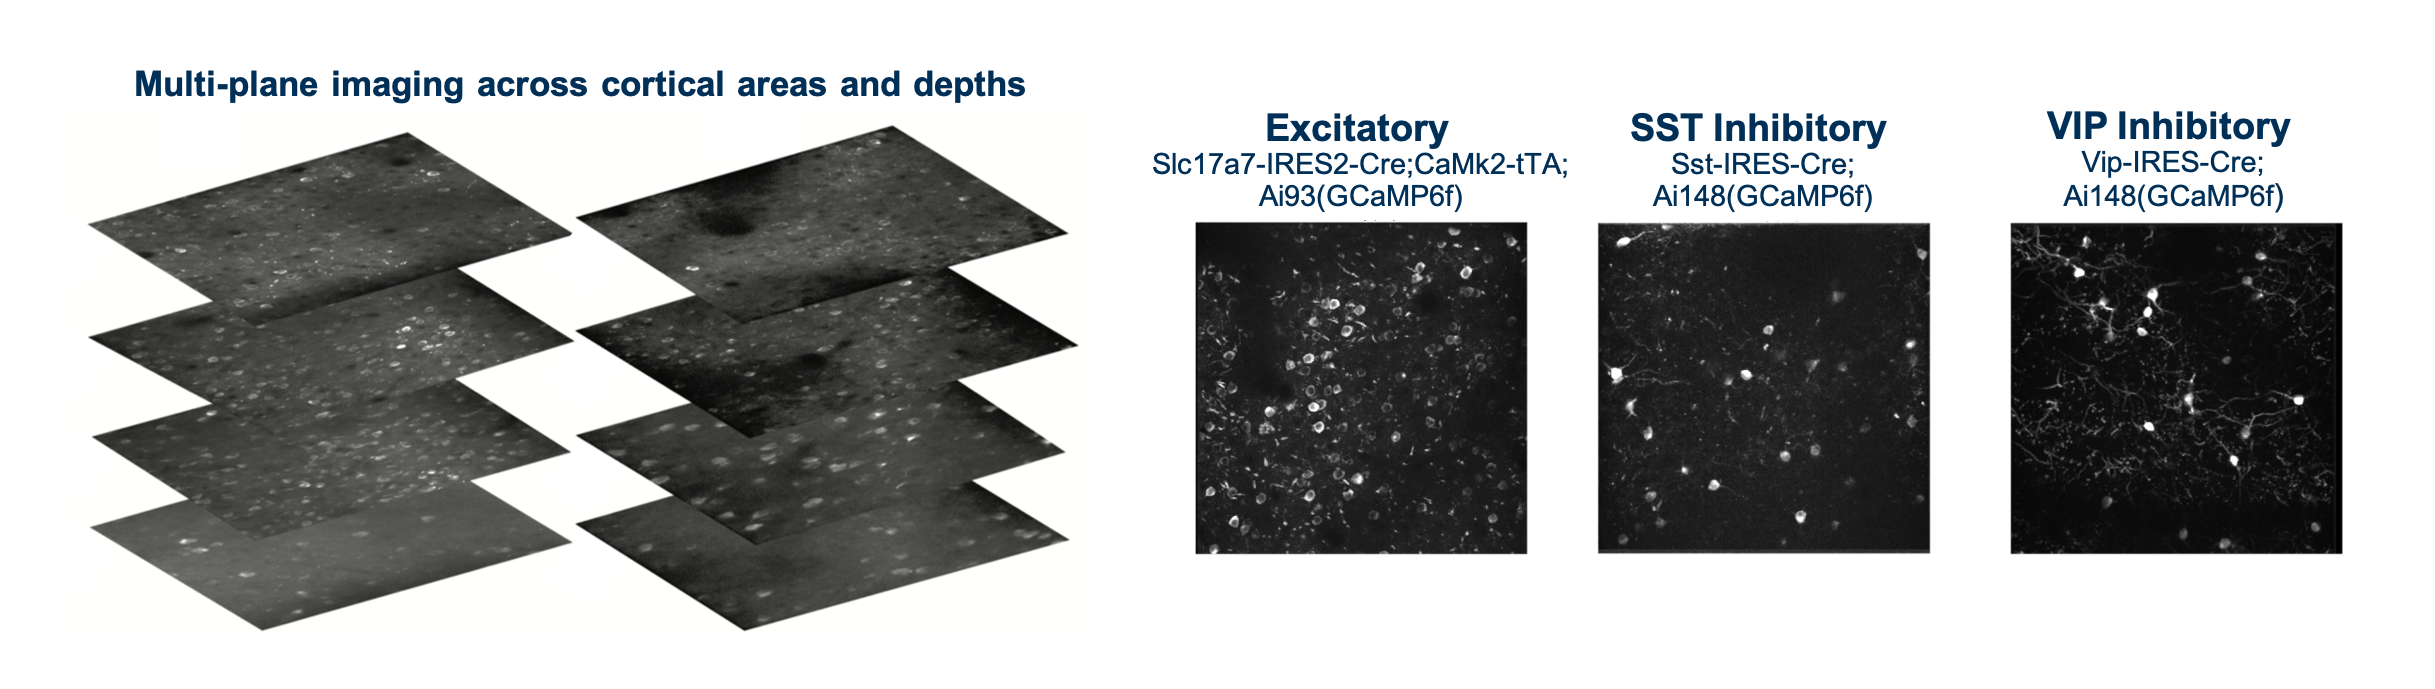

#### You can learn more about this dataset, behavioral task, and find other useful tools here:
#### [Overview page](https://allenswdb.github.io/physiology/ophys/visual-behavior/VB-Ophys.html) and [Allen Brain Atlas](allensdk.readthedocs.io/en/latest/visual_behavior_optical_physiology.html)
#### This example will focus on the activity of the two inhibitory types - VIP and SST neurons.

# Loading the data

In [4]:
# @title Install dependencies

!pip install pandas --quiet
!pip install seaborn --quiet
!pip install  pyarrow # may be needed to read data file

In [5]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

## For this example, we have pre-computed event triggered responses and saved them to figshare.
#### To access the full dataset, see `Allen_neuromatch_example_2.ipynb`, or go to the links at the bottom of this notebook
###This cell will download the responses.

In [ ]:
# @title Data retrieval
import os, requests

fname = "allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet"
url = "https://ndownloader.figshare.com/files/28470255"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

### Then we open it using the pandas `read_parquet` method


(parquet is just another file format)

In [8]:
filename = "allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet"
data = pd.read_parquet(filename)

FileNotFoundError: [Errno 2] No such file or directory: 'allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet'

#### The data is organized as a pandas dataframe.
#### Each row contains all data for a given cell on a given trial


In [7]:
data.sample(5)

NameError: name 'data' is not defined


##### Available data includes:
*   The cell `trace` aligned to stimulus (or omission) onset in a [-1.25, 1.5] second window around onset time
    *   Cell traces are in units of delta F/F, the change in fluorescence relative to baseline
*   The `trace_timestamps` for each trial, aligned to stimulus or omission onset
*   The `mean_response` on a given trial in a 500ms window after stimulus onset
*   The `baseline_response` on a given trial in a 500ms window before stimulus onset
*   The `image_name` for each trial. Trials where the stimulus was omitted have `image_name` = `omitted`
*   The `mean_running_speed` in a 500ms window after stimulus onset
*   The `mean_pupil_area` in a 500ms window after stimulus onset
*   The `response_latency` when the mouse licked after stimulus onset
*   Whether or not the trial was `rewarded`
*   Whether or not the trial `is_change`
*   Whether or not the trial was `omitted`

#### Cell and session level metadata includes:

*   The `stimulus_presentations_id` indicating the trial number within the session
*   The `cell_specimen_id` which is the unique identifier for each cell (note that a cell can be imaged in multiple sessions; if that's the case, the same cell_specimen_id appears in multiple sessions)
*   The `cre_line` indicating the cell type
  *   `Sst-IRES-Cre` labels SST inhibitory cells
  *   `Vip-IRES-Cre` labels VIP inhibitory cells
  *   `Slc17a7-IRES-Cre` labels excitatory cells
*   The `imaging_depth` indicating the cortical depth where the cell was located
*   The `targeted_structure` indicating the cortical area the cell was from
*   The `session_type` indicating the session order and image set
*   The `exposure_level` which tells you whether the image set was familiar or novel
*   The `mouse_id` indicating which mouse the cell came from
*   The `ophys_session_id` indicating the recording day for that trial
*   The `ophys_experiment_id` indicating which imaging plane within the session that the cell came from
*   The `ophys_container_id` which links the same imaging plane recorded across multiple sessions. Cells that are imaged across multiple sessions will have the same `cell_specimen_id`.




### Let's check what is available


In [ ]:
print('exposure_levels:', data.exposure_level.unique())

exposure_levels: ['familiar' 'novel']


In [ ]:
print('stimulus presentations can be changes:', data.is_change.unique())

stimulus presentations can be changes: [ True False]


In [ ]:
print('stimulus presentations can be omitted:', data.omitted.unique())

stimulus presentations can be omitted: [False  True]


In [ ]:
print('cre lines (cell types) included in this dataset are:', data.cre_line.unique())

cre lines (cell types) included in this dataset are: ['Sst-IRES-Cre' 'Vip-IRES-Cre']


In [ ]:
print('there are', len(data.mouse_id.unique()), 'mice in this dataset')

there are 13 mice in this dataset


In [ ]:
print('there are', len(data.ophys_session_id.unique()), 'sessions in this dataset')

there are 25 sessions in this dataset



# How are VIP and SST cells affected by stimulus novelty?

### Plot the population average change response for familiar and novel images for each cre line

Get trials where the image identity changed, for SST and VIP cells

In [ ]:
sst_data = data[(data.cre_line == 'Sst-IRES-Cre')&(data.is_change == True)]
vip_data = data[(data.cre_line == 'Vip-IRES-Cre')&(data.is_change == True)]

Plot the population average change response of SST cells for familiar and novel images

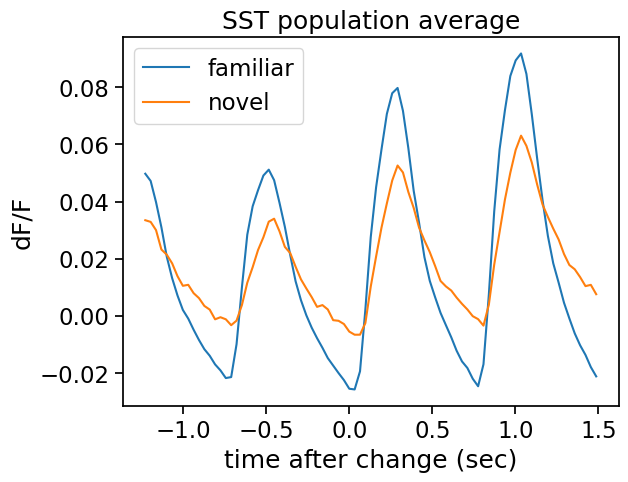

In [ ]:
timestamps = sst_data.trace_timestamps.values[0]
for exposure_level in sst_data.exposure_level.unique():
  traces = sst_data[sst_data.exposure_level==exposure_level].trace.values
  plt.plot(timestamps, np.mean(traces), label=exposure_level)
plt.title('SST population average')
plt.xlabel('time after change (sec)')
plt.ylabel('dF/F')
plt.legend()
plt.show()

Plot the population average change response of VIP cells for familiar and novel images

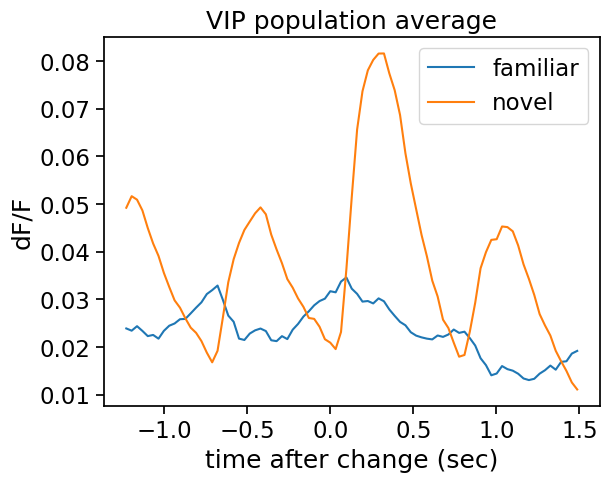

In [ ]:
timestamps = vip_data.trace_timestamps.values[0]
for exposure_level in vip_data.exposure_level.unique():
  traces = vip_data[vip_data.exposure_level==exposure_level].trace.values
  plt.plot(timestamps, np.mean(traces), label=exposure_level)
plt.title('VIP population average')
plt.xlabel('time after change (sec)')
plt.ylabel('dF/F')
plt.legend()
plt.show()

### Can you find cells that were imaged across multiple sessions? How do single cells change depending on the image set?

In [ ]:
# which cells are in more than one session? make a list
cells_in_multiple_sessions_vip = []
for cell_specimen_id in vip_data.cell_specimen_id.unique():
  if len(vip_data[vip_data.cell_specimen_id == cell_specimen_id].ophys_session_id.unique()) > 1:
    cells_in_multiple_sessions_vip.append(cell_specimen_id)

print(len(cells_in_multiple_sessions_vip))

cells_in_multiple_sessions_sst = []
for cell_specimen_id in sst_data.cell_specimen_id.unique():
  if len(sst_data[sst_data.cell_specimen_id == cell_specimen_id].ophys_session_id.unique()) > 1:
    cells_in_multiple_sessions_sst.append(cell_specimen_id)

print(len(cells_in_multiple_sessions_sst))

# print(cells_in_multiple_sessions_vip)

64
38


In [ ]:
# which cells are in more than one session? make a list
cells_in_multiple_sessions_vip = []
for cell_specimen_id in vip_data.cell_specimen_id.unique():
  if len(vip_data[vip_data.cell_specimen_id == cell_specimen_id].ophys_session_id.unique()) > 1:
    cells_in_multiple_sessions_vip.append(cell_specimen_id)

print(len(cells_in_multiple_sessions_vip))

cells_in_multiple_sessions_sst = []
for cell_specimen_id in sst_data.cell_specimen_id.unique():
  if len(sst_data[sst_data.cell_specimen_id == cell_specimen_id].ophys_session_id.unique()) > 1:
    cells_in_multiple_sessions_sst.append(cell_specimen_id)

print(len(cells_in_multiple_sessions_sst))

# print(cells_in_multiple_sessions_vip)

64
38


In [ ]:
cells_in_multiple_sessions_all = []
for cell_specimen_id in data.cell_specimen_id.unique():
  if len(data[data.cell_specimen_id == cell_specimen_id].ophys_session_id.unique()) > 1:
    cells_in_multiple_sessions_all.append(cell_specimen_id)

### SCRATCH - IGNORE THIS SECTION

In [ ]:
len(vip_data.trace_timestamps.values[3][:])

85

In [ ]:
len(sst_data[sst_data.session_number==3])

25380

In [ ]:
cell_id=cells_in_multiple_sessions_vip[0]
vip_data[vip_data.cell_specimen_id==cell_id & vip_data.session_number==3].trace.values[:].shape

TypeError: Cannot perform 'rand_' with a dtyped [float64] array and scalar of type [bool]

In [ ]:
train_set = data[data.session_number==3]
test_set = data[data.session_number==4]

In [ ]:
data_subset = data[(data.is_change==True)|(data.omitted==True)]

In [ ]:
data.head

<bound method NDFrame.head of          stimulus_presentations_id  cell_specimen_id  \
85                               5        1086496689   
86                               5        1086501573   
87                               5        1086500533   
88                               5        1086497438   
89                               5        1086497908   
...                            ...               ...   
1709437                       4795        1086498401   
1709438                       4795        1086498544   
1709439                       4795        1086498699   
1709440                       4795        1086498889   
1709441                       4795        1086498976   

                                                     trace  \
85       [0.06366926431655884, 0.002476318972185254, -0...   
86       [0.0637083426117897, 0.0919334813952446, -0.09...   
87       [0.0223990511149168, 0.22551870346069336, 0.11...   
88       [0.01795899122953415, 0.1527176350355148

In [2]:
data.shape

NameError: name 'data' is not defined

In [3]:
data_subset.shape

NameError: name 'data_subset' is not defined

In [ ]:
cells_in_multiple_sessions_all = []
for cell_specimen_id in data.cell_specimen_id.unique():
  if len(data[data.cell_specimen_id == cell_specimen_id].ophys_session_id.unique()) > 1:
    cells_in_multiple_sessions_all.append(cell_specimen_id)


In [ ]:
help(pd.DataFrame)

Help on class DataFrame in module pandas.core.frame:

class DataFrame(pandas.core.generic.NDFrame, pandas.core.arraylike.OpsMixin)
 |  DataFrame(data=None, index: 'Axes | None' = None, columns: 'Axes | None' = None, dtype: 'Dtype | None' = None, copy: 'bool | None' = None) -> 'None'
 |  
 |  Two-dimensional, size-mutable, potentially heterogeneous tabular data.
 |  
 |  Data structure also contains labeled axes (rows and columns).
 |  Arithmetic operations align on both row and column labels. Can be
 |  thought of as a dict-like container for Series objects. The primary
 |  pandas data structure.
 |  
 |  Parameters
 |  ----------
 |  data : ndarray (structured or homogeneous), Iterable, dict, or DataFrame
 |      Dict can contain Series, arrays, constants, dataclass or list-like objects. If
 |      data is a dict, column order follows insertion-order. If a dict contains Series
 |      which have an index defined, it is aligned by its index.
 |  
 |      .. versionchanged:: 0.25.0
 |  

In [ ]:
subs = [data_subset.cell_specimen_id==i for i in cells_in_multiple_sessions_all]

In [ ]:
subs

[85         False
 86         False
 87         False
 88          True
 89         False
            ...  
 1709437    False
 1709438    False
 1709439    False
 1709440    False
 1709441    False
 Name: cell_specimen_id, Length: 147695, dtype: bool,
 85         False
 86         False
 87         False
 88         False
 89          True
            ...  
 1709437    False
 1709438    False
 1709439    False
 1709440    False
 1709441    False
 Name: cell_specimen_id, Length: 147695, dtype: bool,
 85         False
 86         False
 87         False
 88         False
 89         False
            ...  
 1709437    False
 1709438    False
 1709439    False
 1709440    False
 1709441    False
 Name: cell_specimen_id, Length: 147695, dtype: bool,
 85         False
 86         False
 87         False
 88         False
 89         False
            ...  
 1709437    False
 1709438    False
 1709439    False
 1709440    False
 1709441    False
 Name: cell_specimen_id, Length: 147695, dtype

In [ ]:
data.index(data.cell_specimen_id==i for i in cells_in_multiple_sessions_all)

TypeError: 'Int64Index' object is not callable

In [ ]:
data_subset_multiple = data_subset[[data_subset.cell_specimen_id==i for i in cells_in_multiple_sessions_all]]

KeyError: "None of [Index([      (False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, ...),\n             (False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, ...),\n             (False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, ...),\n             (False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, ...),\n             (False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, ...),\n             (False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, ...),\n             (False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, ...),\n             (False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, ...),\n             (False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, ...),\n             (False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, ...),\n       ...\n       (False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, ...),\n       (False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, ...),\n       (False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, ...),\n       (False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, ...),\n       (False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, ...),\n       (False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, ...),\n       (False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, ...),\n       (False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, ...),\n       (False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, ...),\n       (False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, ...)],\n      dtype='object', length=102)] are in the [columns]"

In [ ]:
data_subset_multiple = pd.DataFrame().reindex_like(data_subset)
i=0
for cell_id in cells_in_multiple_sessions_all:
    data_subset_multiple[i] = data_subset[data_subset.cell_specimen_id==cell_id]
    i=i+1


TypeError: unhashable type: 'slice'

In [ ]:
for cell_id in cells_in_multiple_sessions_sst
data_multiple = data[data.cell_specimen_id cells_in_multiple_sessions_sst]

ValueError: ('Lengths must match to compare', (147695,), (38,))

In [ ]:
train_matrix = np.zeros((len(cells_in_multiple_sessions_vip)+len(cells_in_multiple_sessions_sst), len(vip_data.trace_timestamps.values[0][:])))
test_matrix = np.copy(train_matrix)
vip_train = vip_data[vip_data.session_number==3]
sst_train = sst_data[sst_data.session_number==3]
vip_test = vip_data[vip_data.session_number==4]
sst_test = sst_data[sst_data.session_number==4]
i==0
for cell_id in cells_in_multiple_sessions_vip:
    train_matrix[i,:] = vip_train[vip_train.cell_specimen_id==cell_id].trace.values[0][:]
    i=i+1

ValueError: could not broadcast input array from shape (175,) into shape (85,)

In [ ]:
train_matrix = np.zeros((len(cells_in_multiple_sessions_vip)+len(cells_in_multiple_sessions_sst), len(vip_data.trace_timestamps.values[0][:])))
test_matrix = np.copy(train_matrix)
vip_train = vip_data[vip_data.session_number==3]
sst_train = sst_data[sst_data.session_number==3]
vip_test = vip_data[vip_data.session_number==4]
sst_test = sst_data[sst_data.session_number==4]

In [ ]:
vip_data.omitted.unique()

array([False])

In [ ]:
vip_train[vip_train.cell_specimen_id==cells_in_multiple_sessions_vip[1]]

stimulus_presentations_id  cell_specimen_id  \
303021                         10        1086495538   
303462                         31        1086495538   
303861                         50        1086495538   
304407                         76        1086495538   
305163                        112        1086495538   
...                           ...               ...   
402435                       4744        1086495538   
402897                       4766        1086495538   
403149                       4778        1086495538   
403401                       4790        1086495538   
403716                       4805        1086495538   

                                                    trace  \
303021  [0.04483708739280701, 0.16087880730628967, 0.1...   
303462  [-0.15743280947208405, -0.09274463355541229, -...   
303861  [-0.17826437950134277, -0.16144916415214539, -...   
304407  [0.03497853875160217, 0.07251178473234177, -0....   
305163  [0.03251335024833679, -0.04673675820231438, -0...   
...                                                   ...   
402435  [-0.09652671217918396, 0.018681105226278305, -...   
402897  [-0.08610883355140686, -0.06472445279359818, -...   
403149  [0.11161736398935318, 0.0, -0.0116565534844994...   
403401  [0.07819165289402008, 0.03503100574016571, 0.0...   
403716  [-0.052510816603899, 0.0024926720652729273, 0....   

                                         trace_timestamps  mean_response  \
303021  [-1.2281102725749526, -1.1957915811914013, -1....       0.003805   
303462  [-1.2281102725749526, -1.1957915811914013, -1....       0.067368   
303861  [-1.2281102725749526, -1.1957915811914013, -1....       0.062338   
304407  [-1.2281102725749526, -1.1957915811914013, -1....       0.055583   
305163  [-1.2281102725749526, -1.1957915811914013, -1....       0.092449   
...                                                   ...            ...   
402435  [-1.2281102725749526, -1.1957915811914013, -1....       0.022062   
402897  [-1.2281102725749526, -1.1957915811914013, -1....       0.013030   
403149  [-1.2281102725749526, -1.1957915811914013, -1....      -0.010310   
403401  [-1.2281102725749526, -1.1957915811914013, -1....       0.047456   
403716  [-1.2281102725749526, -1.1957915811914013, -1....      -0.016690   

        baseline_response image_name  image_index  is_change  omitted  ...  \
303021           0.012697      im075            2       True    False  ...   
303462           0.114568      im073            3       True    False  ...   
303861           0.061749      im075            2       True    False  ...   
304407          -0.011582      im106            1       True    False  ...   
305163           0.107436      im031            6       True    False  ...   
...                   ...        ...          ...        ...      ...  ...   
402435          -0.005761      im035            7       True    False  ...   
402897          -0.032615      im106            1       True    False  ...   
403149           0.004309      im075            2       True    False  ...   
403401           0.036496      im073            3       True    False  ...   
403716          -0.043005      im031            6       True    False  ...   

        ophys_session_id  ophys_container_id  behavior_session_id  \
303021         967200850           957570596            967449308   
303462         967200850           957570596            967449308   
303861         967200850           957570596            967449308   
304407         967200850           957570596            967449308   
305163         967200850           957570596            967449308   
...                  ...                 ...                  ...   
402435         967200850           957570596            967449308   
402897         967200850           957570596            967449308   
403149         967200850           957570596            967449308   
403401         967200850           957570596            967449308   
40371

### End of scratch

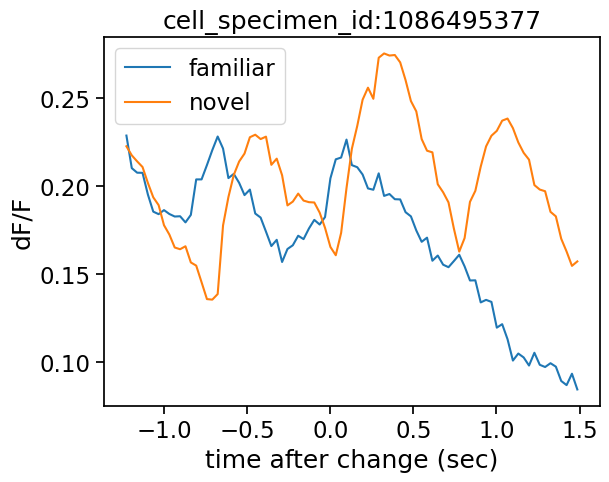

In [ ]:
# this one looks like the population average
cells_in_multiple_sessions = cells_in_multiple_sessions_vip
example_cell_specimen_id = cells_in_multiple_sessions[6]

cell_data = vip_data[vip_data.cell_specimen_id == example_cell_specimen_id]
timestamps = cell_data.trace_timestamps.values[0]
for exposure_level in cell_data.exposure_level.unique():
  mean_trace = cell_data[cell_data.exposure_level == exposure_level].trace.mean()
  plt.plot(timestamps, mean_trace, label=exposure_level)
plt.title(f'cell_specimen_id:{example_cell_specimen_id}')
plt.xlabel('time after change (sec)')
plt.ylabel('dF/F')
plt.legend()
plt.show()

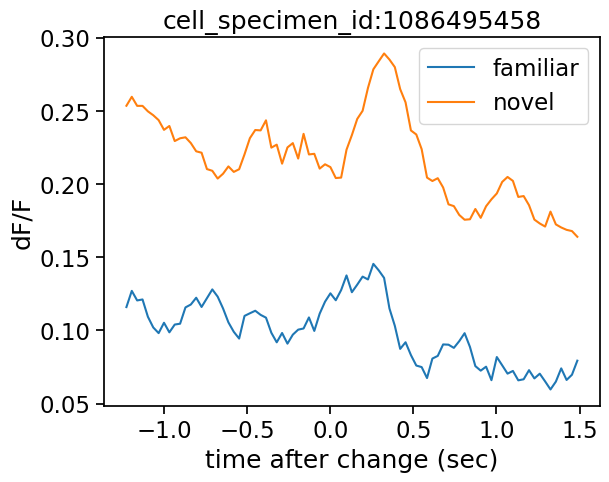

In [ ]:
# this one does not look like the population average
example_cell_specimen_id = cells_in_multiple_sessions[0]

cell_data = vip_data[vip_data.cell_specimen_id==example_cell_specimen_id]
timestamps = cell_data.trace_timestamps.values[0]
for exposure_level in cell_data.exposure_level.unique():
  mean_trace = cell_data[cell_data.exposure_level == exposure_level].trace.mean()
  plt.plot(timestamps, mean_trace, label=exposure_level)
plt.title(f'cell_specimen_id:{example_cell_specimen_id}')
plt.xlabel('time after change (sec)')
plt.ylabel('dF/F')
plt.legend()
plt.show()

### What about trial to trial variability? How does the response of a single cell vary across a session?



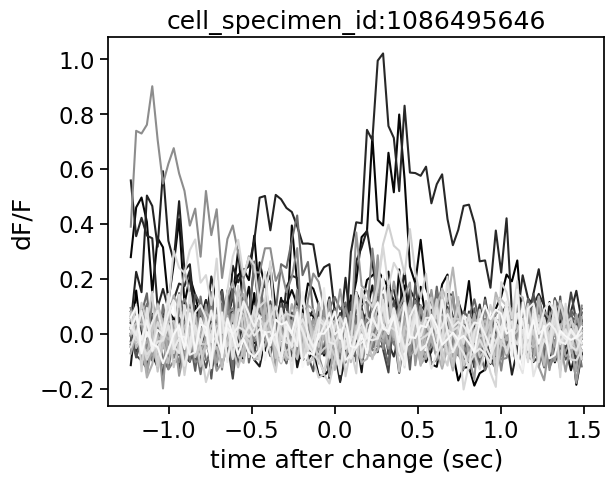

In [ ]:
# let's pick a cell from a novel image session
example_cell_specimen_id = vip_data[vip_data.exposure_level=='novel'].cell_specimen_id.unique()[7]

cell_data = vip_data[vip_data.cell_specimen_id == example_cell_specimen_id]
cell_data = cell_data[(cell_data.image_name == cell_data.image_name.unique()[2])]

offset = 1 / len(cell_data.stimulus_presentations_id.unique())
color = [0, 0, 0]

for i, stimulus_presentations_id in enumerate(cell_data.stimulus_presentations_id.unique()):
  trial_data = cell_data[cell_data.stimulus_presentations_id == stimulus_presentations_id]
  timestamps = trial_data.trace_timestamps.values[0]
  trace = trial_data.trace.values[0]
  plt.plot(timestamps, trace, color = color)
  color = [color[0] + offset, color[1] + offset, color[2] + offset]
plt.title(f'cell_specimen_id:{example_cell_specimen_id}')
plt.xlabel('time after change (sec)')
plt.ylabel('dF/F')
plt.show()

# How do SST and VIP cells respond when stimuli are omitted?¶

### Plot the population average response to stimulus omission

Get trials where the stimulus was omitted, for SST and VIP cells

In [ ]:
sst_data = data[(data.cre_line == 'Sst-IRES-Cre')&(data.omitted == True)]
vip_data = data[(data.cre_line == 'Vip-IRES-Cre')&(data.omitted == True)]

Plot the population average omission response of SST cells for familiar and novel images

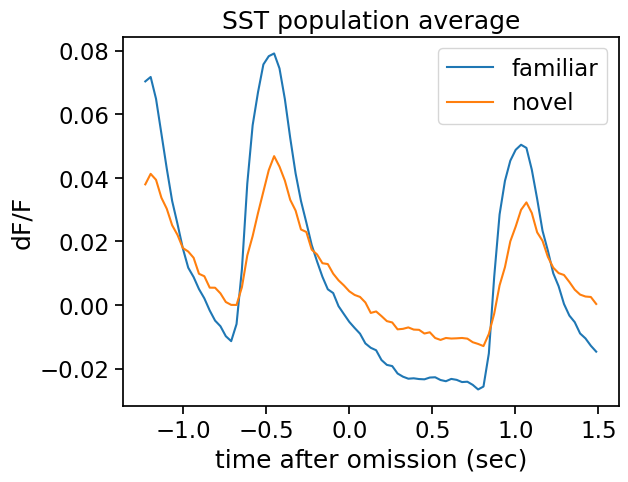

In [ ]:
timestamps = sst_data.trace_timestamps.values[0]
for exposure_level in sst_data.exposure_level.unique():
  traces = sst_data[sst_data.exposure_level == exposure_level].trace.values
  plt.plot(timestamps, np.mean(traces), label=exposure_level)
plt.title('SST population average')
plt.xlabel('time after omission (sec)')
plt.ylabel('dF/F')
plt.legend()
plt.show()

Plot population average omission response of VIP cells for familiar and novel images

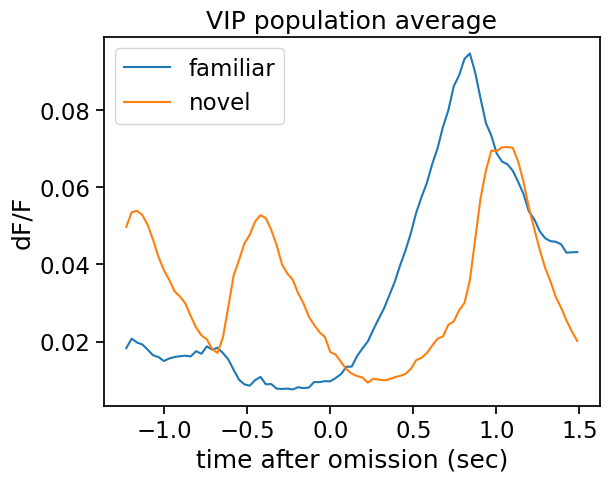

In [ ]:
timestamps = vip_data.trace_timestamps.values[0]  # trace timestamps are relative to stimulus onset
for exposure_level in vip_data.exposure_level.unique():
  traces = vip_data[vip_data.exposure_level == exposure_level].trace.values
  plt.plot(timestamps, np.mean(traces), label=exposure_level)
plt.title('VIP population average')
plt.xlabel('time after omission (sec)')
plt.ylabel('dF/F')
plt.legend()
plt.show()

Does the omission response correlate with behavior?

How do the dynamics of image and omission evoked activity change over time during the novel image session?

### To learn how to use the AllenSDK to access the full dataset, and see more in depth examples of how to interact with the data, check out the additional tutorials here:

https://colab.research.google.com/drive/163dPehppRK6JeHypgfB3gyaGQqKshNQc?usp=sharing

and in the 'Getting Started' section here:

https://allensdk.readthedocs.io/en/latest/visual_behavior_optical_physiology.html




# Project Work Day 4

Please go to your room and familiarize yourself with your data and task. Once you have a good understanding, start with the following analysis strategies:
1. Create PSTHs (Peri-Stimulus Time Histograms) to visualize neuronal firing rates over time in response to stimuli.
2. Plot tuning curves to see how different neurons respond to various stimuli.
3. Use scatter plots to explore relationships between different variables.
4. Look at data across neurons or trials to identify overall trends and variations.
5. Focus on the most tuned neurons to get clearer insights.


### Update
We will skip 1. because it applies to spike data

### 4. Look at data across neurons

Plot traces in response to familiar vs. novel stimuli of all individual neurons

#### SST population: variation across neurons for familiar vs. novel stimuli

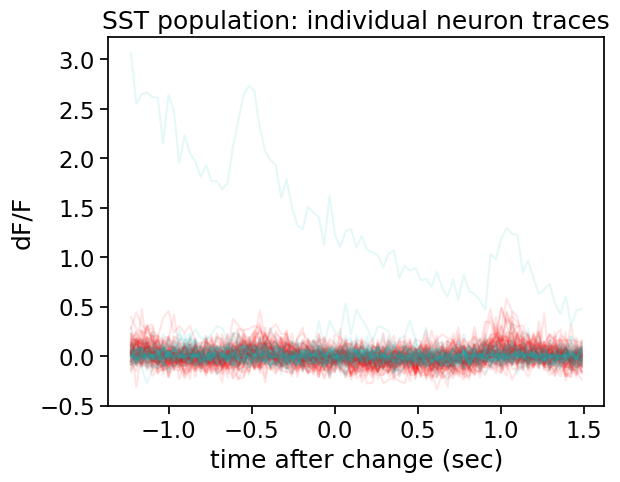

In [ ]:
colours={"familiar": 'r', "novel": 'c'}
for exposure_level in sst_data.exposure_level.unique():
    exposure_data = sst_data[sst_data.exposure_level==exposure_level]
    for neuron in exposure_data.cell_specimen_id.unique():
        timestamps = exposure_data[exposure_data.cell_specimen_id==neuron].trace_timestamps.values[0]
        traces = exposure_data[exposure_data.cell_specimen_id==neuron].trace.values[0]
        plt.plot(timestamps, traces, colours[exposure_level], alpha=0.1)

plt.title('SST population: individual neuron traces')
plt.xlabel('time after change (sec)')
plt.ylabel('dF/F')
plt.show()

Large outlier in data "novel", remove outlier and replot:

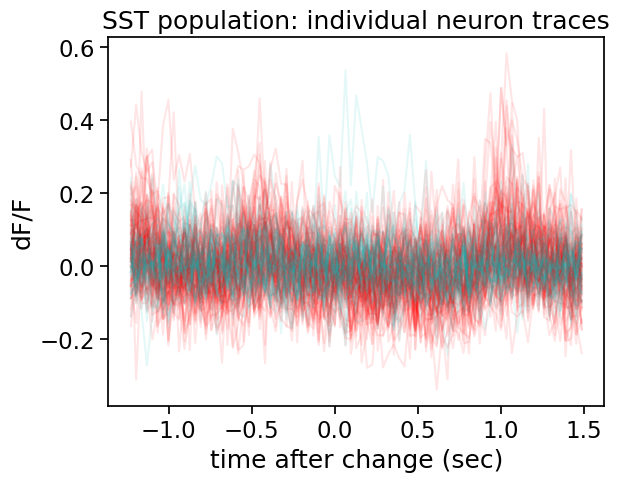

In [ ]:
colours={"familiar": 'r', "novel": 'c'}
for exposure_level in sst_data.exposure_level.unique():
    exposure_data = sst_data[sst_data.exposure_level==exposure_level]
    for neuron in exposure_data.cell_specimen_id.unique():
        timestamps = exposure_data[exposure_data.cell_specimen_id==neuron].trace_timestamps.values[0]
        traces = exposure_data[exposure_data.cell_specimen_id==neuron].trace.values[0]
        if all(traces<2):
            plt.plot(timestamps, traces, colours[exposure_level], alpha=0.1)

plt.title('SST population: individual neuron traces')
plt.xlabel('time after change (sec)')
plt.ylabel('dF/F')
plt.show()

There are still some outliers, but there seems to be overall more variation between neurons in response to familiar stimuli (red). Plot variance over time across neurons by exposure level:

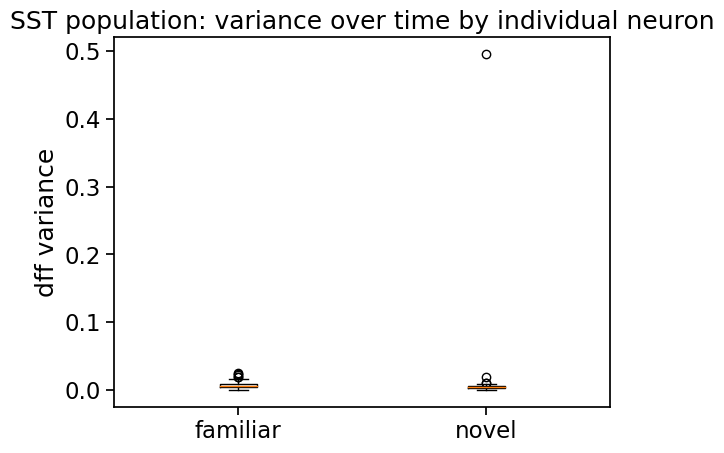

In [ ]:
plt.subplot()
t_var={}
for exposure_level in sst_data.exposure_level.unique():
    exposure_data = sst_data[sst_data.exposure_level==exposure_level]
    t_var[exposure_level] = []
    for neuron in exposure_data.cell_specimen_id.unique():
        timestamps = exposure_data[exposure_data.cell_specimen_id==neuron].trace_timestamps.values[0]
        traces = exposure_data[exposure_data.cell_specimen_id==neuron].trace.values[0]
        varN = np.var(traces)
        t_var[exposure_level].append(varN)

labels, var_data = t_var.keys(), t_var.values()
plt.boxplot(var_data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.title("SST population: variance over time by individual neuron")
plt.ylabel("dff variance")
plt.show()

repeat without outlier

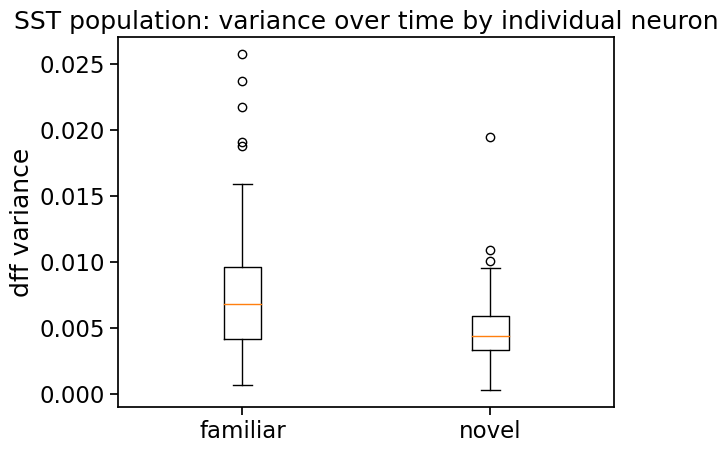

In [ ]:
plt.subplot()
t_var={}
for exposure_level in sst_data.exposure_level.unique():
    exposure_data = sst_data[sst_data.exposure_level==exposure_level]
    t_var[exposure_level] = []
    for neuron in exposure_data.cell_specimen_id.unique():
        timestamps = exposure_data[exposure_data.cell_specimen_id==neuron].trace_timestamps.values[0]
        traces = exposure_data[exposure_data.cell_specimen_id==neuron].trace.values[0]
        if all(traces<2):
            varN = np.var(traces)
            t_var[exposure_level].append(varN)

labels, var_data = t_var.keys(), t_var.values()
plt.boxplot(var_data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.title("SST population: variance over time by individual neuron")
plt.ylabel("dff variance")
plt.show()

This confirms that:
1. there is, on average, larger variation over time in the familiar condition
2. there is more variation between neurons in response to familiar stimuli

#### VIP population: variation across neurons for familiar vs. novel stimuli

Given the average traces above, we expect there to be less variation in familiar stimuli for the VIP population

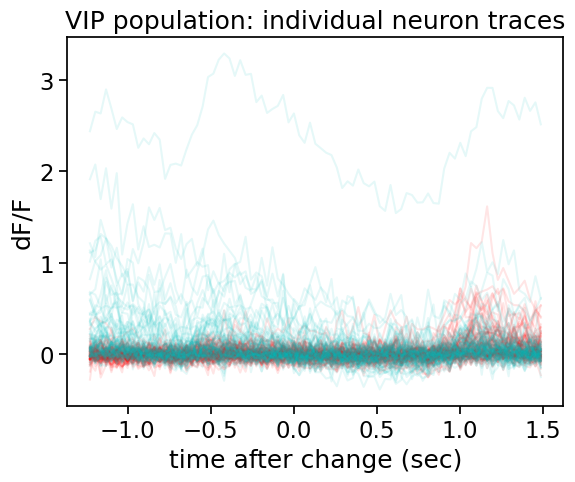

In [ ]:
colours={"familiar": 'r', "novel": 'c'}
for exposure_level in vip_data.exposure_level.unique():
    exposure_data = vip_data[vip_data.exposure_level==exposure_level]
    for neuron in exposure_data.cell_specimen_id.unique():
        timestamps = exposure_data[exposure_data.cell_specimen_id==neuron].trace_timestamps.values[0]
        traces = exposure_data[exposure_data.cell_specimen_id==neuron].trace.values[0]
        plt.plot(timestamps, traces, colours[exposure_level], alpha=0.1)

plt.title('VIP population: individual neuron traces')
plt.xlabel('time after change (sec)')
plt.ylabel('dF/F')
plt.show()

There are several outlier neurons in the VIP population, more than in the SST population. This is especially the case for novel stimuli, but also for familiar (later in the timeseries). Remove outliers and replot

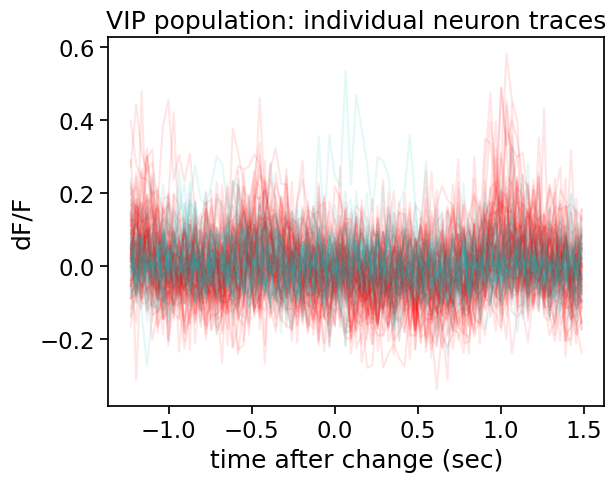

In [ ]:
colours={"familiar": 'r', "novel": 'c'}
for exposure_level in sst_data.exposure_level.unique():
    exposure_data = sst_data[sst_data.exposure_level==exposure_level]
    for neuron in exposure_data.cell_specimen_id.unique():
        timestamps = exposure_data[exposure_data.cell_specimen_id==neuron].trace_timestamps.values[0]
        traces = exposure_data[exposure_data.cell_specimen_id==neuron].trace.values[0]
        if all(traces<2):
            plt.plot(timestamps, traces, colours[exposure_level], alpha=0.1)

plt.title('VIP population: individual neuron traces')
plt.xlabel('time after change (sec)')
plt.ylabel('dF/F')
plt.show()

Plot the variance over time by condition

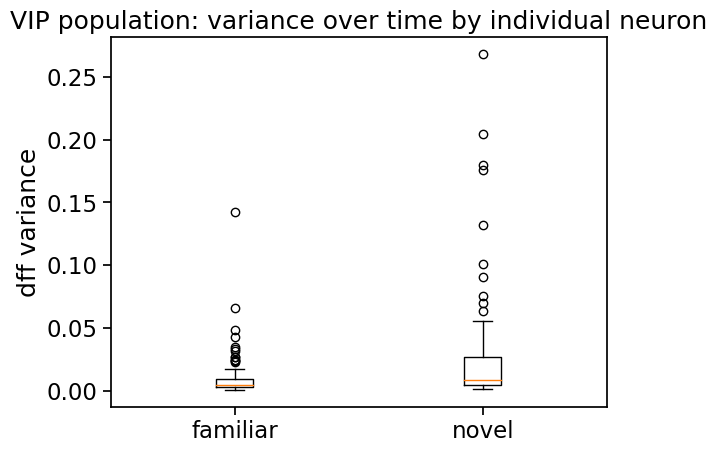

In [ ]:
plt.subplot()
t_var={}
for exposure_level in vip_data.exposure_level.unique():
    exposure_data = vip_data[vip_data.exposure_level==exposure_level]
    t_var[exposure_level] = []
    for neuron in exposure_data.cell_specimen_id.unique():
        timestamps = exposure_data[exposure_data.cell_specimen_id==neuron].trace_timestamps.values[0]
        traces = exposure_data[exposure_data.cell_specimen_id==neuron].trace.values[0]
        varN = np.var(traces)
        t_var[exposure_level].append(varN)

labels, var_data = t_var.keys(), t_var.values()
plt.boxplot(var_data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.title("VIP population: variance over time by individual neuron")
plt.ylabel("dff variance")
plt.show()

Without outliers:

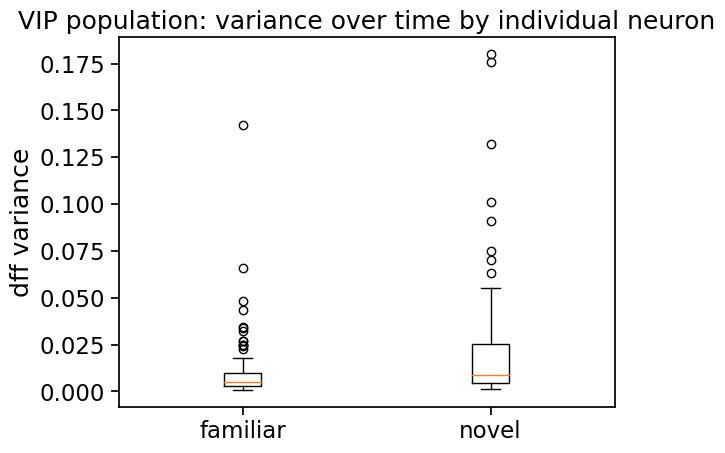

In [ ]:
plt.subplot()
t_var={}
for exposure_level in vip_data.exposure_level.unique():
    exposure_data = vip_data[vip_data.exposure_level==exposure_level]
    t_var[exposure_level] = []
    for neuron in exposure_data.cell_specimen_id.unique():
        timestamps = exposure_data[exposure_data.cell_specimen_id==neuron].trace_timestamps.values[0]
        traces = exposure_data[exposure_data.cell_specimen_id==neuron].trace.values[0]
        varN = np.var(traces)
        if all(traces<2):
            t_var[exposure_level].append(varN)

labels, var_data = t_var.keys(), t_var.values()
plt.boxplot(var_data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.title("VIP population: variance over time by individual neuron")
plt.ylabel("dff variance")
plt.show()

*Question*: Are the individual neurons with large response values outliers or specifically tuned to the stimuli? What would be a reasonable threshold?

# Decoding project

For our project, we want to decode different types of novelty from the Vip and Sst traces. When trying to get the data into the format we need for decoding, we encountered several problems and realised we need to understand the data and format better. Here are some questions we had:

* How can we split data for train and test? What are the different options, advantages/disadvantages? How can we make sure we have the same amount of trials of every condition for training?
* How many specific neurons have recordings from multiple trials?
* How many is_change and omitted trials are there in total? How many in each session?
* What format do we need the data to be in to fit a decoding model?
* What are our options for the decoding model (e.g. logistic regression/other models?)?
* Do all trials have the same number of timepoints?
* Does every session have all conditions or are they block-organised? Do we have data for every condition?
* How many sessions and trials are there?

We need to go back to the full dataframe because the objects `vip_data` and `sst_data` do not only split by cell type but already have certain conditions removed.

How many trials are there in the data?

In [ ]:
data.stimulus_presentations_id.unique().shape

(4215,)

But not all of these trials occur in every session/neuron

How many sessions are there?

In [ ]:
data.session_number.unique()

array([3., 4.])

In [ ]:
data.session_type.unique()

array(['OPHYS_3_images_B', 'OPHYS_4_images_A'], dtype=object)

It looks like there are two sessions, #3 and #4, corresponding to image sets B and A, respectively. Why does it say at the start that there are 12 sessions then?

In [ ]:
len(data.ophys_session_id.unique())

25

It seems like `ophys_session_id` refers to the imaging session, and `session_number`/`session_type` refer to the image sets used. Are the imaging sessions the different planes imaged? According to the description, `ophys_session_id` should be the day of the imaging session, and the planes should be stored in `ophys_experiment_id`:

In [ ]:
len(data.ophys_experiment_id.unique())

25

In [ ]:
print(data.ophys_session_id.unique())
print(data.ophys_experiment_id.unique())

[ 994199725  994731371  994883056  933463604  967200850  967965969
  993231283  993668836  957189583  992783847  993265436  979379271
  981863572 1003555861 1004237014 1010684546 1001860744 1004317427
 1004824790 1005018474  985610440  987623801  961180142  961665529
  963496285]
[ 994278281  994790561  994955425  934476801  967876201  968651977
  993341877  993862120  957652800  992870927  993344860  979668410
  982183920 1003771765 1004403369 1010812025 1002314807 1004405226
 1004889552 1005123568  986402309  988542529  961281512  962473308
  964440177]


The two fields are the same length though. Does that mean that each of the 25 imaging sessions has 25 planes recorded, or is there a different plane recorded at each imaging session?

In [ ]:
for os_id in data.ophys_session_id.unique():
    print(os_id, data[data.ophys_session_id==os_id].ophys_experiment_id.unique())

994199725 [994278281]
994731371 [994790561]
994883056 [994955425]
933463604 [934476801]
967200850 [967876201]
967965969 [968651977]
993231283 [993341877]
993668836 [993862120]
957189583 [957652800]
992783847 [992870927]
993265436 [993344860]
979379271 [979668410]
981863572 [982183920]
1003555861 [1003771765]
1004237014 [1004403369]
1010684546 [1010812025]
1001860744 [1002314807]
1004317427 [1004405226]
1004824790 [1004889552]
1005018474 [1005123568]
985610440 [986402309]
987623801 [988542529]
961180142 [961281512]
961665529 [962473308]
963496285 [964440177]


It looks like at each of the 25 imaging sessions, there was a different plane recorded, so that for our purpose, we can simply calculate with 25 sessions, but be aware that they come from different planes.

Does each imaging session have both image sets (A & B)?

In [ ]:
for os_id in data.ophys_session_id.unique():
    print(os_id, data[data.ophys_session_id==os_id].session_type.unique())

994199725 ['OPHYS_3_images_B']
994731371 ['OPHYS_3_images_B']
994883056 ['OPHYS_4_images_A']
933463604 ['OPHYS_3_images_B']
967200850 ['OPHYS_3_images_B']
967965969 ['OPHYS_4_images_A']
993231283 ['OPHYS_3_images_B']
993668836 ['OPHYS_4_images_A']
957189583 ['OPHYS_3_images_B']
992783847 ['OPHYS_3_images_B']
993265436 ['OPHYS_4_images_A']
979379271 ['OPHYS_3_images_B']
981863572 ['OPHYS_4_images_A']
1003555861 ['OPHYS_3_images_B']
1004237014 ['OPHYS_4_images_A']
1010684546 ['OPHYS_3_images_B']
1001860744 ['OPHYS_3_images_B']
1004317427 ['OPHYS_3_images_B']
1004824790 ['OPHYS_3_images_B']
1005018474 ['OPHYS_4_images_A']
985610440 ['OPHYS_3_images_B']
987623801 ['OPHYS_4_images_A']
961180142 ['OPHYS_3_images_B']
961665529 ['OPHYS_3_images_B']
963496285 ['OPHYS_4_images_A']


No, each imaging session uses either image set A or image set B, in what looks like randomised order.

Do both image sets have novel and familiar stimuli?

In [ ]:
for im_set in data.session_type.unique():
    print(im_set, data[data.session_type==im_set].exposure_level.unique())

OPHYS_3_images_B ['familiar']
OPHYS_4_images_A ['novel']


Image set B is familiar and image set A is novel.

In [ ]:
imset_bysess = []
for os_id in data.ophys_session_id.unique():
    imset_bysess.append(data[data.ophys_session_id==os_id].session_type.unique())

print(imset_bysess.count('OPHYS_3_images_B'))
print(imset_bysess.count('OPHYS_4_images_A'))

16
9


That means, we have 25 imaging sessions, each recorded at a different plane, with either image set A (novel) or B (familiar). There are 16 familiar and 9 novel sessions. From the description, we know that there are 5% omissions in all sessions. **We need to make sure that we have (the same amount?) of familiar as novel in our training set and include omissions in each condition!**

Are there the same number of trials for each session?

Trials are stored in `stimulus_presentations_id`. To get all trials from a single neuron:

In [ ]:
# e.g. one example vip cell, exposure level novel, deviant image
example_cell_specimen_id = vip_data[vip_data.exposure_level=='novel'].cell_specimen_id.unique()[7]

cell_data = vip_data[vip_data.cell_specimen_id == example_cell_specimen_id]
cell_data = cell_data[(cell_data.image_name == cell_data.image_name.unique()[2])]

traces_example = []
for i, stimulus_presentations_id in enumerate(cell_data.stimulus_presentations_id.unique()):
  trial_data = cell_data[cell_data.stimulus_presentations_id == stimulus_presentations_id]
  timestamps = trial_data.trace_timestamps.values[0]
  traces_example.append(trial_data.trace.values[0])



This neuron has 38 trials for this condition

In [ ]:
traces_example[0].shape

(85,)

Each trial has 85 timepoints.

In [ ]:
for os_id in data.ophys_session_id.unique():
    print(os_id, len(data[data.ophys_session_id==os_id].stimulus_presentations_id.unique()))

994199725 484
994731371 478
994883056 442
933463604 448
967200850 442
967965969 478
993231283 380
993668836 379
957189583 498
992783847 315
993265436 345
979379271 401
981863572 367
1003555861 394
1004237014 435
1010684546 326
1001860744 378
1004317427 505
1004824790 335
1005018474 536
985610440 301
987623801 228
961180142 237
961665529 275
963496285 279


Each imaging session has a different number of trials, ranging between 200 and 500.

For splitting the data, we could use cross-validation splitting across sessions (using e.g. k-fold cv from scikit-learn). In that case, we need to make sure that we include the same amount of trials of both image sets, as well as omissions. Alternatively, we could use entire sessions, and assign some imaging sessions with image sets A and B to training and others to testing. However, in that case, we may have a confound (imaging plane).

How many cells occur in multiple sessions?

In [ ]:
cells_in_multiple_sessions_all = []
for cell_specimen_id in data.cell_specimen_id.unique():
  if len(data[data.cell_specimen_id == cell_specimen_id].session_number.unique()) > 1:
    cells_in_multiple_sessions_all.append(cell_specimen_id)

print(len(cells_in_multiple_sessions_all))
print(len(data.cell_specimen_id.unique()))

97
223


97 out of 223 individual neurons recorded occur in multiple imaging sessions. If we want to take into account individual neuron tuning, we need to restrict our analysis to these neurons so that we have responses to both familiar and novel stimuli from the same neuron.

We could use different classifiers in our decoding model. Logistic regression seems like the simplest one and we don't have reasons to believe that there would be a nonlinear relationship. Alternatively, we could use other linear models, e.g. linear discriminant analysis, or simple kernel methods, e.g. SVC. If those don't work, we might try a decision tree

If we want to train timepoint by timepoint (which seems to be the simplest option), we need to organise our data along three dimensions: cell x trial x time. We can then loop over time points to train our model to learn weights for each cell based on all trials. Those will be our feature matrices. For this dataset, that means we will train 85 separate logistic regression models, each taking as x (features) an array containing the trace values of neurons x trials. The labels y should be an array of the four different conditions (familiar_deviant, familiar_omitted, novel_deviant, novel_omitted), encoded as a binary matrix.

The total number of unique stimulus presentations :

In [1]:
# prompt: print the total number of trials

print(len(data.stimulus_presentations_id.unique()))
print(len(data.stimulus_presentations_id))


NameError: name 'data' is not defined

The total number of trials :

In [ ]:
#Each row in the data corresponds to a trial, so :

print(f'Total number of trials: {len(data)}')


Total number of trials: 147695


The number of trials for each neuron :

In [ ]:
# Group by cell_specimen_id and count the number of trials for each neuron
neuron_trial_counts = data.groupby('cell_specimen_id').size().reset_index(name='number_of_trials')

# Print the table
print(neuron_trial_counts)


     cell_specimen_id  number_of_trials
0          1086489847               829
1          1086489860               829
2          1086489882               435
3          1086489891               829
4          1086489901               394
..                ...               ...
218        1086668307               378
219        1086668331               378
220        1086668399               378
221        1086668409               378
222        1086668440               378

[223 rows x 2 columns]


In [ ]:
import pandas as pd

# Assuming `data` is your DataFrame
# Group by 'cell_specimen_id' and count the number of trials for each neuron
neuron_trial_counts = data.groupby('cell_specimen_id').size().reset_index(name='number_of_trials')

# Find the minimum number of trials
min_trials = neuron_trial_counts['number_of_trials'].min()

# Get the neuron IDs with the minimum number of trials
neurons_with_min_trials = neuron_trial_counts[neuron_trial_counts['number_of_trials'] == min_trials]

# Print the minimum number of trials and the corresponding neuron IDs
print(f"The minimum number of trials is: {min_trials}")
print("Neuron IDs with the minimum number of trials:")
print(neurons_with_min_trials)


The minimum number of trials is: 275
Neuron IDs with the minimum number of trials:
     cell_specimen_id  number_of_trials
116        1086499205               275
122        1086499684               275


In [ ]:
# Assuming `data` is your DataFrame
# Group by 'cell_specimen_id' and count the number of trials for each neuron
neuron_trial_counts = data.groupby('cell_specimen_id').size().reset_index(name='number_of_trials')

# Find the maximum number of trials
max_trials = neuron_trial_counts['number_of_trials'].max()

# Get the neuron IDs with the maximum number of trials
neurons_with_max_trials = neuron_trial_counts[neuron_trial_counts['number_of_trials'] == max_trials]

# Print the maximum number of trials and the corresponding neuron IDs
print(f"The maximum number of trials is: {max_trials}")
print("Neuron IDs with the maximum number of trials:")
print(neurons_with_max_trials)
# Print the DataFrame without the index
print(neurons_with_max_trials.to_string(index=False))



The maximum number of trials is: 1404
Neuron IDs with the maximum number of trials:
     cell_specimen_id  number_of_trials
78         1086496500              1404
86         1086497034              1404
87         1086497129              1404
100        1086497908              1404
103        1086498071              1404
111        1086498820              1404
114        1086498977              1404
117        1086499316              1404
127        1086500121              1404
 cell_specimen_id  number_of_trials
       1086496500              1404
       1086497034              1404
       1086497129              1404
       1086497908              1404
       1086498071              1404
       1086498820              1404
       1086498977              1404
       1086499316              1404
       1086500121              1404


In [ ]:
# Print the DataFrame without the index
print(neurons_with_max_trials.to_string(index=False))


 cell_specimen_id  number_of_trials
       1086496500              1404
       1086497034              1404
       1086497129              1404
       1086497908              1404
       1086498071              1404
       1086498820              1404
       1086498977              1404
       1086499316              1404
       1086500121              1404


In [ ]:

sst_cells = data[data['cre_line'] == 'Sst-IRES-Cre']
vip_cells = data[data['cre_line'] == 'Vip-IRES-Cre']

# Count number of trials for each group
sst_trials = sst_cells.groupby('cell_specimen_id').size()
vip_trials = vip_cells.groupby('cell_specimen_id').size()

# Calculate total number of trials for SST and VIP cells
total_sst_trials = sst_trials.sum()
total_vip_trials = vip_trials.sum()

# Print the total number of trials for SST and VIP cells
print("Total trials for SST cells:", total_sst_trials)
print("Total trials for VIP cells:", total_vip_trials)


Total trials for SST cells: 59481
Total trials for VIP cells: 88214
